In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt

In [2]:
print(tf.__version__)

1.14.0


In [19]:
# Definimos algumas funções auxiliares importantes aqui:
def media(lst: list):
    m = 0
    for num in lst:
        m += num
    return m / len(lst)

def preencher_lacunas(lst):
    '''
    Substitui valores None  de uma lista por um valor aproximado. É calculada 
    a equação de reta dada pelos últimos pontos anterioes e estima-se um valor 
    para o ponto de valor None.
    '''
    lista = []
    # Copiando a lista
    for num in lst:
        lista.append(num)

    for i in range(len(lista)):
        if not lista[i] >= 0:
            if i - 2 >= 0:
                amt = lista[i - 1] - lista[i - 2]
                lista[i] = lista[i - 1] + amt
            elif i - 1 >= 0:
                lista[i] = lista[i - 1]
        if lista[i] < 0:
            lista[i] = 0

    return np.array(lista, dtype=float)

def gerar_dias_do_ano(ano):
    '''
    Gera um array contendo todos os dias de um determinado ano no formato
    dd/mm/aaaa.
    '''
    num_dias_meses = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    dias = []
    if ano % 4 == 0: # verificamos se o ano é bissexto
        num_dias_meses[1] = 29

    for mes in range(len(num_dias_meses)):
        num_dias = num_dias_meses[mes]
        for dia in range(num_dias):
            dia_str = str(dia + 1)
            mes_str = str(mes + 1)
            if dia + 1 < 10:
                dia_str = f'0{dia + 1}'

            # as listas são indexadas começando por 0, mas os meses são indexados começando
            # por 1
            if mes + 1 < 10:
                mes_str = f'0{mes + 1}'

            data = f'{dia_str}/{mes_str}/{ano}'
            dias.append(data)

    return np.array(dias)

def mediasDiarias_Ano(ano, medida):
    '''
    Retorna as médias diárias do arquivo  de caminho f'dados/{medida}_{ano}.csv'
    '''
    path = f'dados/{medida}_{ano}.csv'
    dados = pd.read_csv(path)

    # Definindo a medida padrão como ppb
    FATOR_CONVERSAO = 1
    if dados["Unidade de medida"].loc[0] == 'ppb':
        FATOR_CONVERSAO = 0.001
  
    # datas = np.unique(dados["Data"].to_numpy())
    datas = gerar_dias_do_ano(ano)
    # print('Tamanho de datas:', len(datas))
    y = []
    for data in datas:
        try:
            medias_horarias = dados[dados.Data == data]["Media horaria"].to_numpy()
            # print(medias_horarias[:10])
            media_diaria = media(medias_horarias)
            # print(media_diaria)
            y.append(media_diaria * FATOR_CONVERSAO)
        except:
            y.append(None)
    x = np.array([n + 1 for n in range(len(datas))], dtype=int)
    return np.array(y, dtype=float)

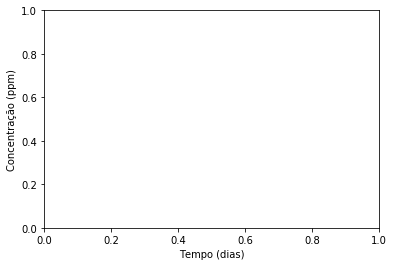

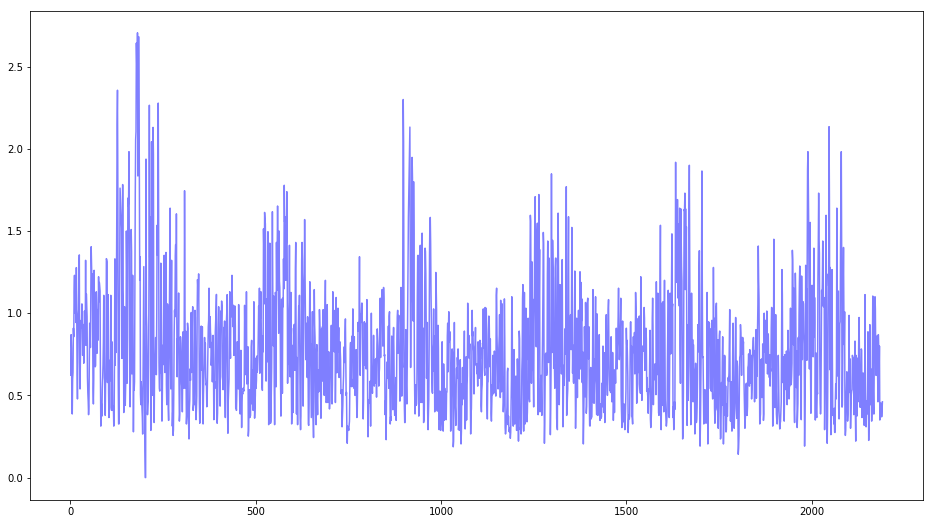

In [20]:
# Plotando os gráficos
plt.xlabel('Tempo (dias)')
plt.ylabel('Concentração (ppm)')

medias_diarias = mediasDiarias_Ano(2014, 'CO')
medias_diarias = np.concatenate((medias_diarias, mediasDiarias_Ano(2015, 'CO')))
medias_diarias = np.concatenate((medias_diarias, mediasDiarias_Ano(2016, 'CO')))
medias_diarias = np.concatenate((medias_diarias, mediasDiarias_Ano(2017, 'CO')))
medias_diarias = np.concatenate((medias_diarias, mediasDiarias_Ano(2018, 'CO')))
medias_diarias = np.concatenate((medias_diarias, mediasDiarias_Ano(2019, 'CO')))
dias = np.array([x + 1 for x in range(len(medias_diarias))], dtype=int)

# substituindo os valores em branco por valores plausíveis
medias_diarias = preencher_lacunas(medias_diarias)

plt.figure(figsize=(16, 9))
plt.plot(dias, medias_diarias, color='blue', alpha=0.5)
plt.show()

Agora que temos os valores das médias em um único array, podemos utilizá-los para treinar uma rede neural. Mas antes, iremos dividir os valores em "janelas" para utilizar de input para a nossa rede.

In [22]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    '''
    Transforma uma lista ou array em um objeto do tipo tf.data.Dataset para se utilizar de
    input para a rede neural. 
    '''
    dataset = tf.data.Dataset.from_tensor_slices(series) # Cria o Dataset a partir de uma lista/array
    
    # Cria janelas de tamanho window_size + 1. A janela do Dataset precisa ter um espaço a mais
    # para alocar o output desejado:
    #
    # [[input], [output desejado]]
    #
    # O tamanho da lista de inputs é window_size, e o output é de tamanho 1, por queremos saber o
    # valor seguinte dado um trecho da série temporal
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    
    # Embaralhamos os dados para não enviesar o modelo.
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    
    # Por fim, criamos amostras consecutivas de tamanho batch_size
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

tempo_treino = 365 * 4 # treinar usando dados de 4 anos

treino = medias_diarias[:tempo_treino]
dias_treino = dias[:tempo_treino]

teste = medias_diarias[tempo_treino:]
dias_teste = dias[tempo_treino:]


janela = 365
batch_size, shuffle_buffer = 32, 1000
dataset = windowed_dataset(medias_diarias, janela, batch_size, shuffle_buffer)

Criando e treinando o modelo:

In [23]:
# criando uma DNN


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=[janela]),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss='mse', optimizer=opt, metrics=['mae'])
historico = model.fit(dataset, epochs=300, verbose=1)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Epoch 1/500
58/58 [==============================] - 1s 21ms/step - loss: 0.1247 - mean_absolute_error: 0.2742
Epoch 2/500
58/58 [==============================] - 1s 12ms/step - loss: 0.1038 - mean_absolute_error: 0.2585
Epoch 3/500
58/58 [==============================] - 1s 12ms/step - loss: 0.0953 - mean_absolute_error: 0.2468
Epoch 4/500
58/58 [==============================] - 1s 12ms/step - loss: 0.0771 - mean_absolute_error: 0.2241
Epoch 5/500
58/58 [==============================] - 1s 12ms/step - loss: 0.0857 - mean_absolute_error: 0.2357
Epoch 6/500
58/58 [==============================] - 1s 13ms/step - loss: 0.0714 - mean_absolute_error: 0.2145
Epoch 7/500
58/58 [==============================] - 1s 15ms/step - loss: 0.0655 - mean_absolute_error: 0.2053
Epoch 8/500
58/58 [==============================] - 1s 13ms/step - loss: 0.0596 - mean_absolute_error: 0

58/58 [==============================] - 1s 12ms/step - loss: 1.3901e-06 - mean_absolute_error: 7.7972e-04
Epoch 70/500
58/58 [==============================] - 1s 12ms/step - loss: 1.2482e-06 - mean_absolute_error: 7.4731e-04
Epoch 71/500
58/58 [==============================] - 1s 14ms/step - loss: 1.2558e-06 - mean_absolute_error: 7.4779e-04
Epoch 72/500
58/58 [==============================] - 1s 16ms/step - loss: 1.4094e-06 - mean_absolute_error: 8.7727e-04
Epoch 73/500
58/58 [==============================] - 1s 12ms/step - loss: 9.6774e-07 - mean_absolute_error: 6.7810e-04
Epoch 74/500
58/58 [==============================] - 1s 12ms/step - loss: 7.6834e-07 - mean_absolute_error: 5.9524e-04
Epoch 75/500
58/58 [==============================] - 1s 12ms/step - loss: 7.0336e-07 - mean_absolute_error: 5.6468e-04
Epoch 76/500
58/58 [==============================] - 1s 12ms/step - loss: 6.8843e-07 - mean_absolute_error: 5.4646e-04
Epoch 77/500
58/58 [==============================] -

58/58 [==============================] - 1s 12ms/step - loss: 7.8976e-10 - mean_absolute_error: 1.3987e-05
Epoch 138/500
58/58 [==============================] - 1s 13ms/step - loss: 7.5417e-10 - mean_absolute_error: 1.4206e-05
Epoch 139/500
58/58 [==============================] - 1s 13ms/step - loss: 7.9021e-10 - mean_absolute_error: 1.5288e-05
Epoch 140/500
58/58 [==============================] - 1s 13ms/step - loss: 6.8853e-10 - mean_absolute_error: 1.4578e-05
Epoch 141/500
58/58 [==============================] - 1s 12ms/step - loss: 1.2115e-09 - mean_absolute_error: 1.5074e-05
Epoch 142/500
58/58 [==============================] - 1s 13ms/step - loss: 1.6721e-09 - mean_absolute_error: 3.0290e-05
Epoch 143/500
58/58 [==============================] - 1s 12ms/step - loss: 9.3178e-10 - mean_absolute_error: 2.0526e-05
Epoch 144/500
58/58 [==============================] - 1s 12ms/step - loss: 5.6744e-10 - mean_absolute_error: 1.4668e-05
Epoch 145/500
58/58 [=========================

58/58 [==============================] - 1s 12ms/step - loss: 1.2871e-11 - mean_absolute_error: 1.7806e-06
Epoch 205/500
58/58 [==============================] - 1s 12ms/step - loss: 1.0275e-11 - mean_absolute_error: 1.3078e-06
Epoch 206/500
58/58 [==============================] - 1s 12ms/step - loss: 1.0186e-11 - mean_absolute_error: 1.3743e-06
Epoch 207/500
58/58 [==============================] - 1s 12ms/step - loss: 9.6585e-12 - mean_absolute_error: 1.2853e-06
Epoch 208/500
58/58 [==============================] - 1s 12ms/step - loss: 9.6760e-12 - mean_absolute_error: 1.3840e-06
Epoch 209/500
58/58 [==============================] - 1s 12ms/step - loss: 9.0847e-12 - mean_absolute_error: 1.2637e-06
Epoch 210/500
58/58 [==============================] - 1s 13ms/step - loss: 9.5065e-12 - mean_absolute_error: 1.2427e-06
Epoch 211/500
58/58 [==============================] - 1s 12ms/step - loss: 9.6568e-12 - mean_absolute_error: 1.5233e-06
Epoch 212/500
58/58 [=========================

58/58 [==============================] - 1s 12ms/step - loss: 2.5577e-12 - mean_absolute_error: 7.3446e-07
Epoch 272/500
58/58 [==============================] - 1s 13ms/step - loss: 2.4689e-12 - mean_absolute_error: 7.0297e-07
Epoch 273/500
58/58 [==============================] - 1s 13ms/step - loss: 2.4781e-12 - mean_absolute_error: 6.8419e-07
Epoch 274/500
58/58 [==============================] - 1s 13ms/step - loss: 2.5146e-12 - mean_absolute_error: 7.3784e-07
Epoch 275/500
58/58 [==============================] - 1s 12ms/step - loss: 2.4838e-12 - mean_absolute_error: 7.5366e-07
Epoch 276/500
58/58 [==============================] - 1s 12ms/step - loss: 2.4125e-12 - mean_absolute_error: 7.3349e-07
Epoch 277/500
58/58 [==============================] - 1s 12ms/step - loss: 2.2811e-12 - mean_absolute_error: 6.6757e-07
Epoch 278/500
58/58 [==============================] - 1s 12ms/step - loss: 2.2471e-12 - mean_absolute_error: 6.5581e-07
Epoch 279/500
58/58 [=========================

58/58 [==============================] - 1s 12ms/step - loss: 1.0526e-12 - mean_absolute_error: 4.7524e-07
Epoch 339/500
58/58 [==============================] - 1s 12ms/step - loss: 1.0434e-12 - mean_absolute_error: 4.6288e-07
Epoch 340/500
58/58 [==============================] - 1s 12ms/step - loss: 1.0535e-12 - mean_absolute_error: 4.8689e-07
Epoch 341/500
58/58 [==============================] - 1s 12ms/step - loss: 1.0199e-12 - mean_absolute_error: 4.6562e-07
Epoch 342/500
58/58 [==============================] - 1s 12ms/step - loss: 1.0251e-12 - mean_absolute_error: 4.6935e-07
Epoch 343/500
58/58 [==============================] - 1s 13ms/step - loss: 1.0239e-12 - mean_absolute_error: 4.7676e-07
Epoch 344/500
58/58 [==============================] - 1s 12ms/step - loss: 9.9499e-13 - mean_absolute_error: 4.6181e-07
Epoch 345/500
58/58 [==============================] - 1s 12ms/step - loss: 9.8669e-13 - mean_absolute_error: 4.5968e-07
Epoch 346/500
58/58 [=========================

58/58 [==============================] - 1s 12ms/step - loss: 7.6506e-13 - mean_absolute_error: 3.7894e-07
Epoch 406/500
58/58 [==============================] - 1s 12ms/step - loss: 7.2623e-13 - mean_absolute_error: 4.7471e-07
Epoch 407/500
58/58 [==============================] - 1s 12ms/step - loss: 6.2015e-13 - mean_absolute_error: 3.9126e-07
Epoch 408/500
58/58 [==============================] - 1s 12ms/step - loss: 6.0897e-13 - mean_absolute_error: 3.8652e-07
Epoch 409/500
58/58 [==============================] - 1s 12ms/step - loss: 5.9343e-13 - mean_absolute_error: 3.7102e-07
Epoch 410/500
58/58 [==============================] - 1s 12ms/step - loss: 5.9406e-13 - mean_absolute_error: 3.8262e-07
Epoch 411/500
58/58 [==============================] - 1s 12ms/step - loss: 6.0186e-13 - mean_absolute_error: 3.6926e-07
Epoch 412/500
58/58 [==============================] - 1s 12ms/step - loss: 5.8681e-13 - mean_absolute_error: 3.7581e-07
Epoch 413/500
58/58 [=========================

58/58 [==============================] - 1s 12ms/step - loss: 3.9789e-13 - mean_absolute_error: 3.1024e-07
Epoch 473/500
58/58 [==============================] - 1s 12ms/step - loss: 3.9864e-13 - mean_absolute_error: 3.1495e-07
Epoch 474/500
58/58 [==============================] - 1s 12ms/step - loss: 3.9354e-13 - mean_absolute_error: 3.1562e-07
Epoch 475/500
58/58 [==============================] - 1s 12ms/step - loss: 3.9216e-13 - mean_absolute_error: 3.1587e-07
Epoch 476/500
58/58 [==============================] - 1s 12ms/step - loss: 3.8848e-13 - mean_absolute_error: 3.0832e-07
Epoch 477/500
58/58 [==============================] - 1s 12ms/step - loss: 3.8891e-13 - mean_absolute_error: 3.1575e-07
Epoch 478/500
58/58 [==============================] - 1s 12ms/step - loss: 3.8118e-13 - mean_absolute_error: 3.0550e-07
Epoch 479/500
58/58 [==============================] - 1s 12ms/step - loss: 3.8990e-13 - mean_absolute_error: 3.1171e-07
Epoch 480/500
58/58 [=========================

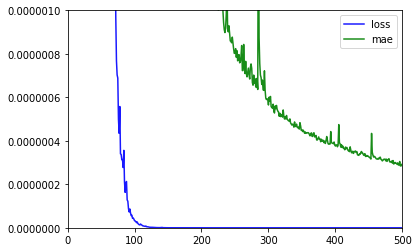

In [25]:
# Fazendo uma visualização da curva de aprendizado do modelo

loss = historico.history['loss']
mae = historico.history['mean_absolute_error']
epochs = [x for x in range(len(loss))]

plt.plot(epochs, loss, color='blue', alpha=0.9)
plt.plot(epochs, mae, color='green', alpha=0.9)
plt.axis([0, len(loss), 0, 1e-6])
plt.legend(['loss', 'mae'])

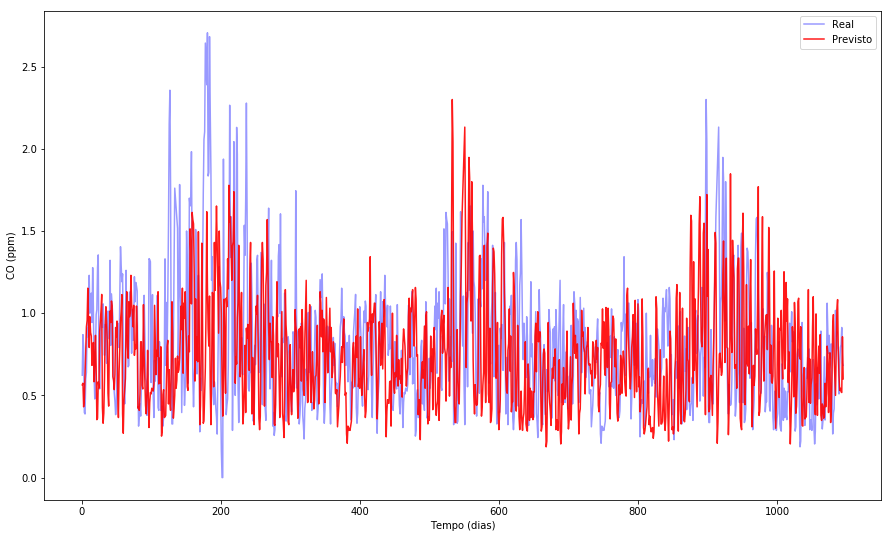

In [26]:
# Prevendo resultados
forecast = []
for dia in range(len(treino) - janela):
    arr = np.array(treino[dia:dia + janela][np.newaxis])
    forecast.append(model.predict(arr)[0])

plt.figure(figsize=[15, 9])
plt.xlabel('Tempo (dias)')
plt.ylabel('CO (ppm)')
plt.plot(dias_treino[:-janela], treino[:-janela], color='blue', alpha=0.4)
plt.plot(dias_treino[:-janela], forecast, color='red', alpha=0.9)
plt.legend(['Real', 'Previsto'])
plt.show()